#### Imports & Comments

Data Sourc UNHCR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kstest
import statsmodels.api as sm

In [2]:
seek_df = pd.read_csv('preprocessed_data.csv')

In [11]:
# colors
c1 = '#a14242' 
c2 = '#a3b8c8'
c3 = '#d28140'
c4 = '#119988'

# Country Asylum Application Decision Analysis Tool
Within this noteboom you can to select a country of interest for a detailed analysis. This interactive tool provides several key insights through different analytical views:
1. A time-series graph of the country's absolute numbers of rejected and accepted asylum applications, offering an immediate visualization of trends over recent years. This feature facilitates a quick understanding of how a country's asylum decisions have evolved.
2. A list of the primary countries of origin for asylum seekers applying to the selected country. This overview allows users to gauge the main sources of asylum applications and understand the direct impact of global migration patterns on the chosen country.
2. An evaluation of the predictability of a country's asylum decisions based on linear regression models, comparing its behavior to global trends. This aspect assesses how closely a country's asylum decision trends align with broader patterns.
3. A graph depicting the country's year-over-year rate of change in accepted and rejected asylum applications, accompanied by correlation and linear regression analyses (using both Spearman and Pearson coefficients). This parallels the methodologies applied in figures \ref{figs:canada} and \ref{figs:usa}, helping users determine whether there appears to be a policy or strategy regulating the balance between accepted and rejected applications.
4. A comparison of Rate of Change distributions, similar to the analysis in figure \ref{figs:usa_ecdf}. This comparison aims to highlight differences in distributions and assess whether one or both are centered around zero with a small standard deviation, potentially indicating a cap on asylum decisions.

## Pick a country

list of all countries:

In [4]:
print(list(seek_df['country_asylum'].unique()), end=', ')

['Zimbabwe', 'South Africa', 'Uzbekistan', 'United States of America', 'Ukraine', 'Turkey', 'Turkmenistan', 'Tajikistan', 'Thailand', 'Syrian Arab Rep.', 'Sweden', 'Slovenia', 'Slovakia', 'Serbia and Kosovo (S/RES/1244 (1999))', 'Russian Federation', 'Romania', 'Portugal', 'Poland', 'Nepal', 'Norway', 'Netherlands', 'Malaysia', 'Mozambique', 'The former Yugoslav Republic of Macedonia', 'Mexico', 'Rep. of Moldova', 'Luxembourg', 'Lithuania', 'Sri Lanka', 'Lebanon', 'Kuwait', 'Cambodia', 'Kyrgyzstan', 'Kenya', 'Kazakhstan', 'Japan', 'Jordan', 'Italy', 'Iceland', 'Iran (Islamic Rep. of)', 'Ireland', 'India', 'Indonesia', 'Hungary', 'Croatia', 'China, Hong Kong SAR', 'Greece', 'United Kingdom', 'France', 'Finland', 'Ethiopia', 'Estonia', 'Spain', 'Egypt', 'Denmark', 'Germany', 'Czech Rep.', 'Cyprus', 'Cuba', 'China', 'Switzerland', 'Canada', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Bangladesh', 'Belgium', 'Azerbaijan', 'Austria', 'Australia', 'Argentina', 'United Arab Emirates', '

Now write your country of choice as _mycountry_:

In [7]:
mycountry = 'Austria'

Check if country is spelled right:

In [8]:
if mycountry in list(seek_df['country_asylum'].unique()):
    print('Yes, ', mycountry, ' is in the list.')
else:
    print('Check if you have a spelling mistake or if the country is not in the list.')

Yes,  Austria  is in the list.


## 1. Countries Absolute Decisions over time

In [18]:
def plt_absoulte_decisions(country):
    fig, ax = plt.subplots(figsize=(7, 4))

    country_df = seek_df.copy()[seek_df['country_asylum'] == country]
    country_df = country_df.groupby(['year']).sum()

    #plot accepted numbers
    sns.lineplot(data=country_df,
                x=country_df.index,
                y="accepted",
                label="Accepted Applications",
                c=c3)
    ax.fill_between(country_df.index, country_df['accepted'], color=c3, alpha=0.3)


    temp_r_df = country_df.copy()
    temp_r_df['rejected'] = temp_r_df['rejected'] + temp_r_df['accepted']

    sns.lineplot(data=temp_r_df,
                x=country_df.index,
                y="rejected",
                label="Rejected Applications",
                c=c4)
    ax.fill_between(country_df.index, temp_r_df['rejected'], country_df['accepted'], color=c4, alpha=0.3)

    # Place the legend in the center top
    plt.legend(loc='upper left', bbox_to_anchor=(0.3, .98), ncol=1)

    plt.title(country + ' Accepted/Rejected/Pending Asylum Applications')
    plt.xlabel('Year')
    plt.ylabel('Number of Applications  per year')
    plt.show()

c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hutte\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

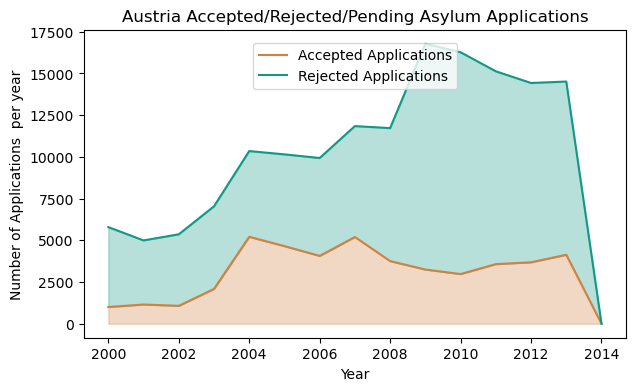

In [19]:
plt_absoulte_decisions(mycountry)

## 2. Refugees Country of Origin

In [20]:
mycountry_df = seek_df.copy()[seek_df['country_asylum'] == mycountry]

In [29]:
def plt_origin_countries(mycountry):
    # number of refugees per country of origin in total
    df_rc = mycountry_df[["country_origin", "applications"]]
    df_rc = df_rc.groupby('country_origin').sum()
    df_rc = df_rc.sort_values(by='applications', ascending=False)

    # plot the top 10 countries with most refugees
    df_rc.head(15).sort_values(by='applications', ascending=True).plot(kind='barh', figsize=(7, 3), color=c1)
    plt.title('Countries where most refugees are coming from\n for application country ' + mycountry)
    plt.xlabel('Number of Applications')
    plt.legend().remove()
    plt.ylabel('')
    plt.show()
    return

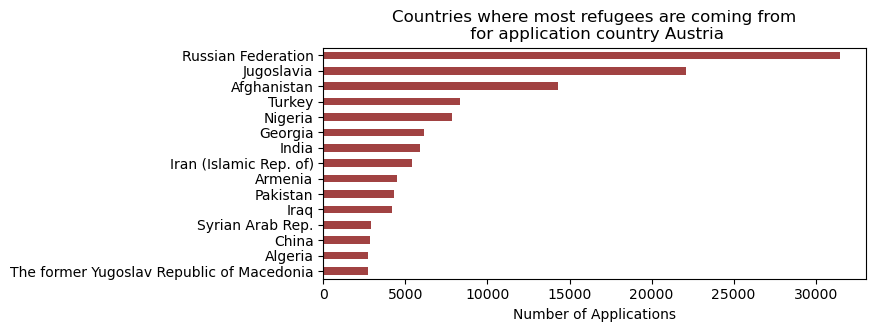

In [31]:
plt_origin_countries(mycountry)

## 3. My Countries positon in Global Trend

In [70]:
def plt_global_trend_position(mycountry):
    fig, ax = plt.subplots(figsize=(7, 4))

    country_df = seek_df[['country_asylum','rejected','accepted']].copy().groupby('country_asylum').sum()
    country_df['country_asylum'] = country_df.index
    # calculate linear regression
    x = country_df['accepted']
    y = country_df['rejected']

    x = sm.add_constant(x)
    model_sm = sm.OLS(y,x).fit()
    R2 = model_sm.rsquared

    # plot the data
    sns.scatterplot(data=country_df, x='accepted', y='rejected', c=c3, label='Countries')

    # plot mycountry
    rejected_values = country_df.loc[country_df['country_asylum'] == mycountry, 'rejected'].values
    accepted_values = country_df.loc[country_df['country_asylum'] == mycountry, 'accepted'].values
    plt.scatter(accepted_values, rejected_values, color='red', s= 50, marker='o', label=mycountry)


    # get linear regression mode
    a = model_sm.params['const']
    b = model_sm.params['accepted']

    x_pred = sorted(country_df['accepted'].tolist())

    lin_reg = lambda x: a + b * x
    y_pred = [lin_reg(i) for i in x_pred]

    # plot the linear regression
    plt.plot(x_pred, y_pred, color=c1, label="lin. reg.")

    # plot parameters and information
    plt.text(.5, .03, '$Rejected = %.2f + %.2f \cdot Accepted$'%(a,b), transform=ax.transAxes)
    #plt.text(.05, .89, '$R^2 = %.2f$'%(R2), transform=ax.transAxes)

    plt.xlabel('Number of Accepted Applications')
    plt.ylabel('Number of Rejected Applications')
    plt.title('Linear Regression Countries\n Accumulated Accepted vs Rejected Asylum Applications ', fontsize=15)
    plt.legend( loc='upper left')

    plt.xscale('log')
    plt.yscale('log')
    plt.show()

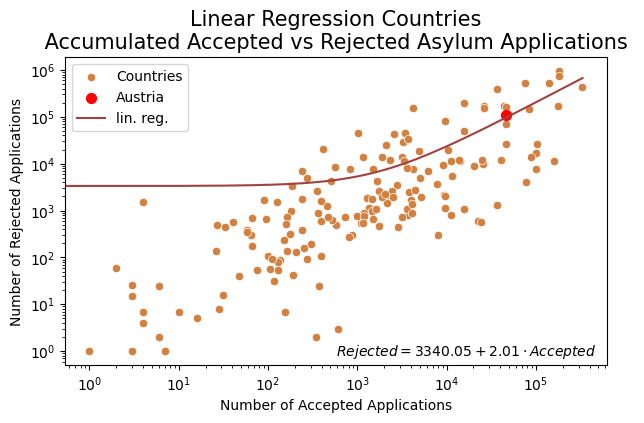

In [68]:
plt_global_trend_position(mycountry)

## 4.

## 5.